In [1]:
from pathlib import Path
from IPython.display import HTML, display

css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 3 — Exploratory Data Analysis (EDA)
## Lesson 1: Visualizing Data Distributions


### What you will learn

By the end of this lesson you will be able to:

- Explain what a *data distribution* is, and why it is central to Exploratory Data Analysis (EDA) and to model selection.
- Visualize numeric distributions with histograms, kernel density estimates (KDE), empirical cumulative distribution functions (ECDF), and quantile–quantile (Q–Q) plots.
- Visualize categorical distributions with bar charts, stacked/proportional bars, and contingency tables.
- Compare distributions across groups (e.g., by class label) using faceted plots, box/violin plots, and overlaid densities.
- Make principled choices for histogram bin width and smoothing parameters.
- Diagnose distribution problems that frequently break machine learning pipelines: heavy tails, skewness, outliers, and distribution shift between splits.

Throughout the lesson we will use several datasets from the repository so you see a variety of distribution types:
continuous, discrete, categorical, and mixed-type data.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Seaborn is optional; the notebook works without it.
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

# SciPy is optional; it provides convenience functions for Q–Q plots and tests.
try:
    from scipy import stats
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

from pathlib import Path


In [3]:
def read_csv_rel(rel_path: str) -> pd.DataFrame:
    """Read a CSV using a repository-relative path (from this notebook folder)."""
    p = Path(rel_path)
    if not p.exists():
        raise FileNotFoundError(
            f"Could not find file at: {p.resolve()}\n"
            "Make sure you run this notebook from within the cloned repository."
        )
    return pd.read_csv(p)

def quick_overview(df: pd.DataFrame, name: str = "DataFrame", n: int = 5) -> None:
    print(f"{name}: shape={df.shape}")
    display(df.head(n))
    print("\nColumn types:")
    display(df.dtypes.to_frame("dtype"))
    print("\nMissing values (%):")
    miss = (df.isna().mean() * 100).sort_values(ascending=False)
    display(miss.to_frame("missing_%").head(20))

def set_plot_style():
    plt.rcParams.update({
        "figure.figsize": (9, 5),
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

set_plot_style()


In [4]:
def freedman_diaconis_bins(x) -> int:
    """Return a reasonable number of histogram bins using the Freedman–Diaconis rule.

    Accepts a pandas Series, NumPy array, or any 1D array-like. Non-numeric values are coerced to NaN.
    """
    x = pd.Series(np.asarray(x).ravel())
    x = pd.to_numeric(x, errors="coerce").dropna().to_numpy()
    n = x.size
    if n < 2:
        return 10

    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25

    # If IQR is zero (many repeated values), fall back to sqrt(n) rule of thumb.
    if iqr <= 0:
        return max(5, min(int(np.ceil(np.sqrt(n))), 200))

    bin_width = 2 * iqr / (n ** (1 / 3))
    if bin_width <= 0:
        return max(5, min(int(np.ceil(np.sqrt(n))), 200))

    data_range = x.max() - x.min()
    if data_range <= 0:
        return max(5, min(int(np.ceil(np.sqrt(n))), 200))

    bins = int(np.ceil(data_range / bin_width))
    return max(5, min(bins, 200))
def ecdf(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna().to_numpy()
    x = np.sort(x)
    y = np.arange(1, x.size + 1) / x.size
    return x, y

def overlay_hist(ax, series_list, labels, bins=30, density=True, alpha=0.35):
    for s, lab in zip(series_list, labels):
        arr = pd.to_numeric(s, errors="coerce").dropna().to_numpy()
        ax.hist(arr, bins=bins, density=density, alpha=alpha, label=lab)
    ax.legend()



### 1) Why “distribution” is the first object of EDA

A dataset is not only a set of rows; it is a sample from an (unknown) data-generating process.
EDA aims to *characterize that process* before you fit models.

A distribution answers questions like:

- **Where is the mass?** Typical values (location).
- **How spread out is it?** Variability (scale).
- **Is it symmetric?** Skewness and heavy tails.
- **Are there multiple regimes?** Multimodality (mixtures / segments).
- **Are there rare but extreme values?** Outliers and tail risk.
- **Does it change across groups or time?** Conditional distributions and drift.

Many machine learning failures are distribution failures:

- A linear model fits poorly because the response is heavy-tailed and the variance is dominated by rare extremes.
- A classifier collapses because a feature’s distribution differs in production (covariate shift).
- A pipeline leaks information because a “post-outcome” feature produces an unnatural distribution separation.

A useful mental model is: you observe $x_1, x_2, \ldots, x_n$ as i.i.d. samples from a distribution with
density $f(x)$ (or probability mass function for discrete data).
From this sample you build *estimators* of distributional quantities.

Two foundational estimators are:

- The **empirical distribution function** (ECDF):
  $$
  \hat F_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{x_i \le x\}.
  $$
- The **sample mean** and **sample variance**:
  $$
  \bar x = \frac{1}{n}\sum_{i=1}^n x_i, \qquad
  s^2 = \frac{1}{n-1}\sum_{i=1}^n (x_i-\bar x)^2.
  $$

However, summary statistics alone are not enough. Two very different distributions can share the same mean and variance.
Visualizations let you see *shape*.



### 2) Histograms as density estimators (and how to choose bins)

A histogram is more than a picture; it is a **nonparametric density estimator**.

Let the bin width be $h > 0$. For a bin interval $B_j = [a + (j-1)h,\ a + jh)$,
the histogram density estimate can be written as:
$$
\hat f_h(x) = \frac{1}{nh}\sum_{i=1}^n \mathbf{1}\{x_i \in B_j\} \quad \text{for } x \in B_j.
$$

The choice of $h$ controls a bias–variance tradeoff:

- **Too small $h$**: high variance, the histogram is noisy.
- **Too large $h$**: high bias, important structure is smoothed away.

Two classical, data-driven rules for $h$ are:

1) **Scott’s rule** (uses standard deviation):
$$
h_{\text{Scott}} = \frac{3.5\,s}{n^{1/3}}.
$$

2) **Freedman–Diaconis rule** (uses IQR for robustness):
$$
h_{\text{FD}} = \frac{2\,\text{IQR}}{n^{1/3}},
\qquad \text{IQR} = Q_{0.75} - Q_{0.25}.
$$

In practice, these rules give a *starting point*.
For machine learning EDA, you still want to inspect sensitivity:
if your conclusions change drastically when you alter $h$, that is itself a signal.


In [5]:
# Dataset 1 (Regression): diamonds
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
diamonds = read_csv_rel(diamonds_path)

quick_overview(diamonds, name="diamonds")


diamonds: shape=(53940, 11)


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75



Column types:


,dtype
id,int64
carat,float64
cut,object
color,object
clarity,object
depth,float64
table,float64
price,int64
x,float64
y,float64



Missing values (%):


,missing_%
id,0.0
carat,0.0
cut,0.0
color,0.0
clarity,0.0
depth,0.0
table,0.0
price,0.0
x,0.0
y,0.0


price summary:


,price
count,53940.000000
mean,3932.799722
std,3989.439738
min,326.000000
1%,429.000000
5%,544.000000
25%,950.000000
50%,2401.000000
75%,5324.250000
95%,13107.100000


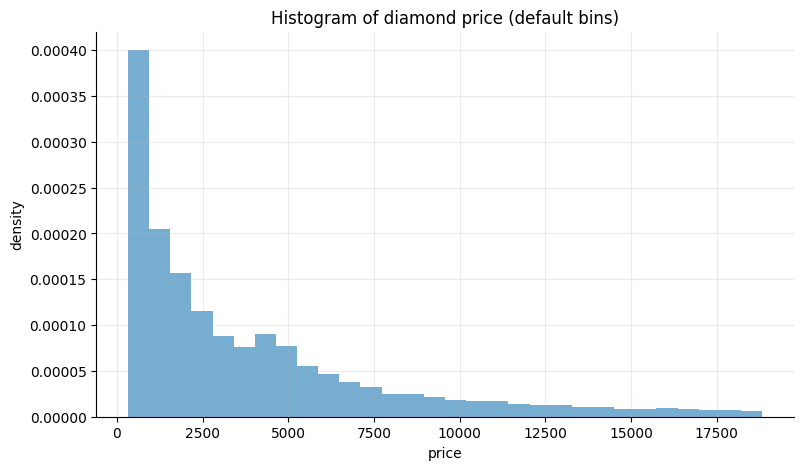

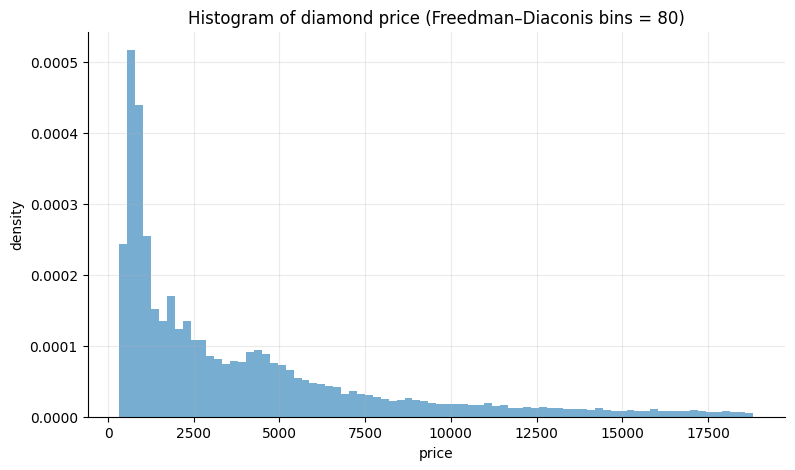

In [6]:
# Focus variable: price (numeric, heavy-tailed)
price = pd.to_numeric(diamonds["price"], errors="coerce").dropna()

print("price summary:")
display(price.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).to_frame("price"))

bins_default = 30
bins_fd = freedman_diaconis_bins(price)

fig, ax = plt.subplots()
ax.hist(price, bins=bins_default, density=True, alpha=0.6)
ax.set_title("Histogram of diamond price (default bins)")
ax.set_xlabel("price")
ax.set_ylabel("density")
plt.show()

fig, ax = plt.subplots()
ax.hist(price, bins=bins_fd, density=True, alpha=0.6)
ax.set_title(f"Histogram of diamond price (Freedman–Diaconis bins = {bins_fd})")
ax.set_xlabel("price")
ax.set_ylabel("density")
plt.show()


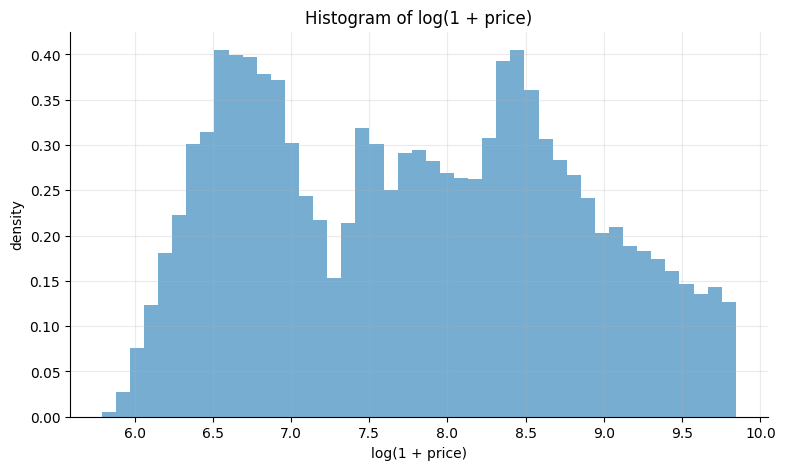

log(1 + price) summary:


,log1p(price)
count,53940.000000
mean,7.787424
std,1.014111
min,5.789960
25%,6.857514
50%,7.784057
75%,8.580215
max,9.842888


In [7]:
# Heavy tails often become easier to interpret on a log scale.
# (We use log1p to handle any zeros gracefully.)
log_price = np.log1p(price)

fig, ax = plt.subplots()
ax.hist(log_price, bins=freedman_diaconis_bins(log_price), density=True, alpha=0.6)
ax.set_title("Histogram of log(1 + price)")
ax.set_xlabel("log(1 + price)")
ax.set_ylabel("density")
plt.show()

print("log(1 + price) summary:")
display(pd.Series(log_price).describe().to_frame("log1p(price)"))



### 3) Kernel Density Estimation (KDE): smooth distributions

A KDE estimates a density by centering a kernel $K$ at every data point and averaging:
$$
\hat f_h(x) = \frac{1}{nh}\sum_{i=1}^n K\!\left(\frac{x-x_i}{h}\right).
$$

For the Gaussian kernel:
$$
K(u) = \frac{1}{\sqrt{2\pi}} e^{-u^2/2}.
$$

Interpretation:

- $h$ is the **bandwidth**. Larger $h$ produces smoother estimates.
- KDE is often easier to compare across groups than histograms.

Caveats you must remember in EDA:

- KDE can **hide discrete structure** if data are integer-valued.
- KDE near boundaries (e.g., values constrained to be positive) can be biased.
- For very large $n$, KDE can be expensive (though fast approximations exist).

KDE is a great complement to histograms, not a replacement.


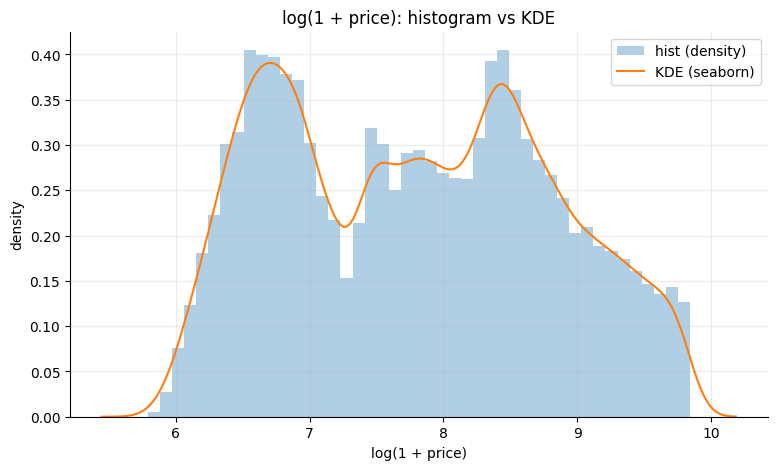

In [8]:
# KDE: compare histogram vs KDE
fig, ax = plt.subplots()
ax.hist(log_price, bins=freedman_diaconis_bins(log_price), density=True, alpha=0.35, label="hist (density)")
if _HAS_SEABORN:
    sns.kdeplot(log_price, ax=ax, label="KDE (seaborn)")
ax.set_title("log(1 + price): histogram vs KDE")
ax.set_xlabel("log(1 + price)")
ax.set_ylabel("density")
ax.legend()
plt.show()



### 4) ECDF and Q–Q plots: distribution shape without binning

**ECDF** has no bins and no bandwidth. It is a step function that accumulates mass.
Two key advantages:

- It is stable: small changes in plotting choices do not cause large changes in shape.
- It is easy to compare multiple groups by overlaying ECDF curves.

A **Q–Q plot** compares the quantiles of your sample to the quantiles of a reference distribution.
For a normal Q–Q plot, you plot:
- $x$-axis: theoretical normal quantiles,
- $y$-axis: sample quantiles.

If your data are approximately normal, the points lie close to a straight line.
Systematic curvature indicates skewness or heavy tails.

In ML, you use Q–Q plots mainly for:
- checking if a transformation (e.g., $\log$) makes a distribution more symmetric,
- diagnosing heavy-tailed targets that can destabilize regression loss functions.


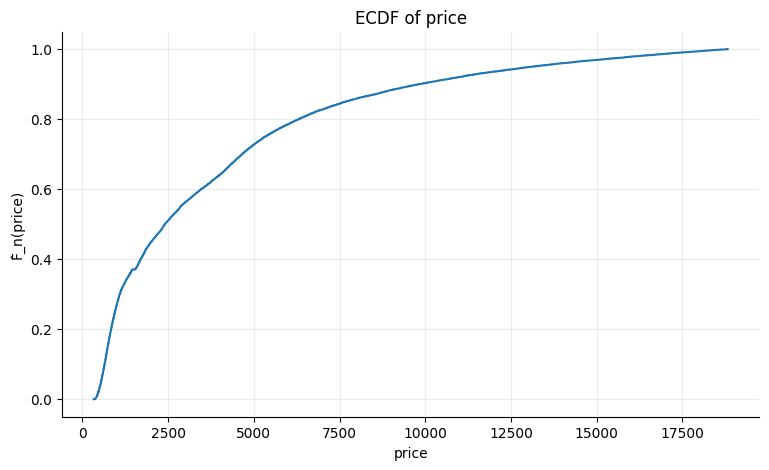

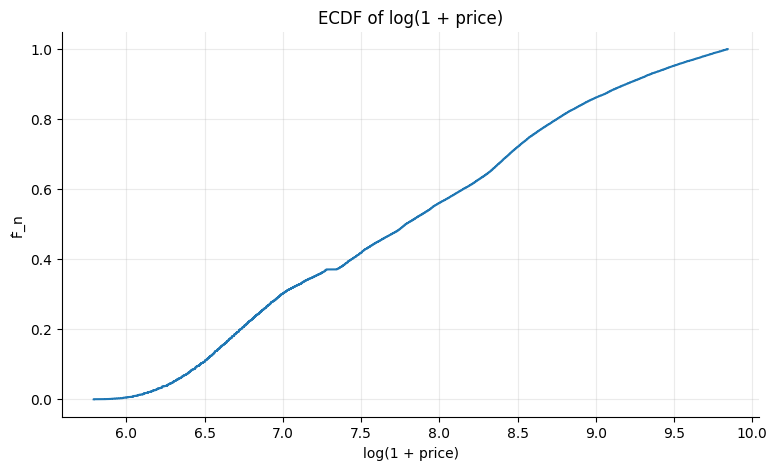

In [9]:
# ECDF: cumulative view of the distribution
x_ecdf, y_ecdf = ecdf(price)

fig, ax = plt.subplots()
ax.step(x_ecdf, y_ecdf, where="post")
ax.set_title("ECDF of price")
ax.set_xlabel("price")
ax.set_ylabel("F̂_n(price)")
plt.show()

# ECDF on log scale can also be informative for heavy tails
x_ecdf_l, y_ecdf_l = ecdf(log_price)
fig, ax = plt.subplots()
ax.step(x_ecdf_l, y_ecdf_l, where="post")
ax.set_title("ECDF of log(1 + price)")
ax.set_xlabel("log(1 + price)")
ax.set_ylabel("F̂_n")
plt.show()


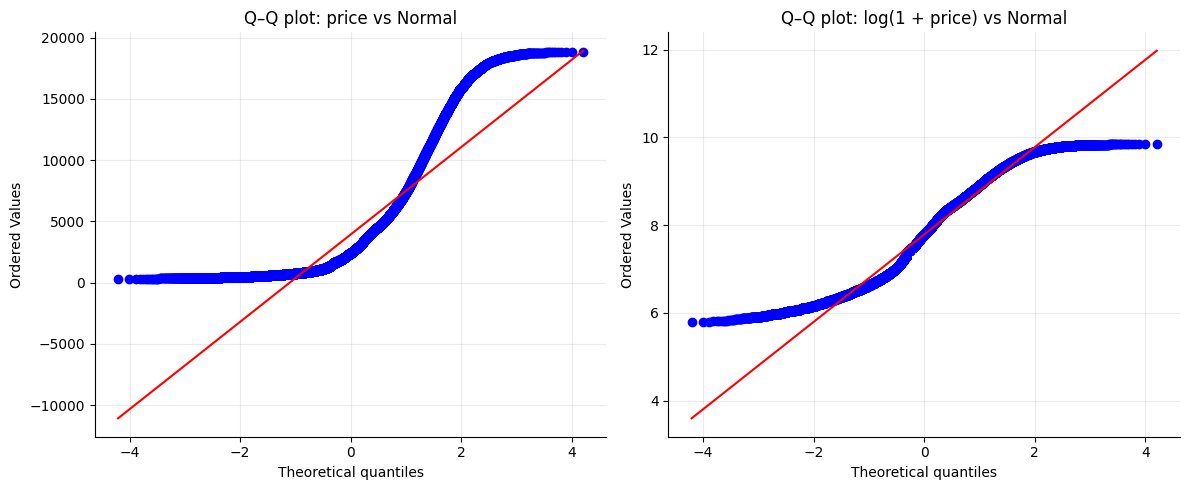

In [10]:
# Q–Q plot: does log(1 + price) look closer to normal than price?
def qq_plot(ax, x: np.ndarray, title: str):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 5:
        ax.text(0.5, 0.5, "Not enough data", ha="center", va="center")
        ax.set_title(title)
        return
    if _HAS_SCIPY:
        stats.probplot(x, dist="norm", plot=ax)
        ax.set_title(title)
    else:
        # Minimal Q–Q without SciPy: compare sample quantiles to theoretical normal quantiles
        x_sorted = np.sort(x)
        n = x_sorted.size
        p = (np.arange(1, n + 1) - 0.5) / n
        # Approximate inverse CDF of standard normal using numpy's erfinv if available
        try:
            from math import sqrt
            from numpy import erfinv
            z = sqrt(2) * erfinv(2 * p - 1)
        except Exception:
            z = np.linspace(-3, 3, n)
        ax.scatter(z, x_sorted, s=10, alpha=0.7)
        # reference line
        a, b = np.polyfit(z, x_sorted, 1)
        ax.plot(z, a * z + b)
        ax.set_title(title)
        ax.set_xlabel("theoretical quantiles (approx)")
        ax.set_ylabel("sample quantiles")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
qq_plot(axes[0], price.to_numpy(), "Q–Q plot: price vs Normal")
qq_plot(axes[1], log_price.to_numpy(), "Q–Q plot: log(1 + price) vs Normal")
plt.tight_layout()
plt.show()



### 5) Comparing distributions across groups (conditional distributions)

Univariate plots answer “what is the distribution of $X$?”.
In machine learning, the more actionable question is often:

- “What is the distribution of $X$ **given** group $G$?” i.e. $X \mid G$.

Examples:

- Feature distributions by class label (to understand separability).
- Target distributions by segment (to see heterogeneity).
- Train vs validation vs test distributions (to detect drift).

We will use the diamonds dataset and compare price across the categorical variable `cut`.

Why `cut` is useful:

- It is a *human-defined* category (quality grade),
- It meaningfully changes the distribution of price,
- It demonstrates how to compare multiple groups without losing the overall picture.


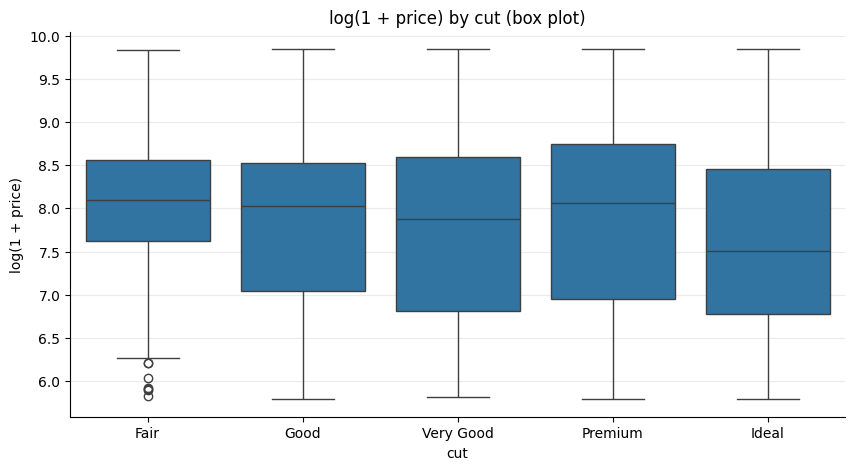

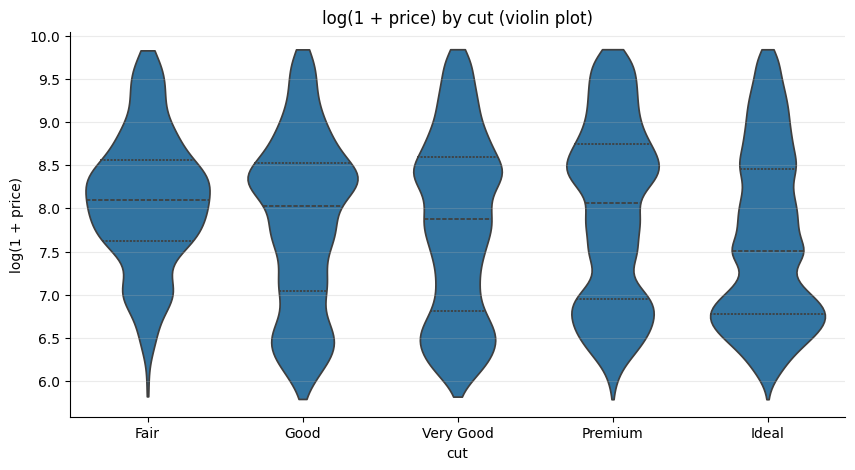

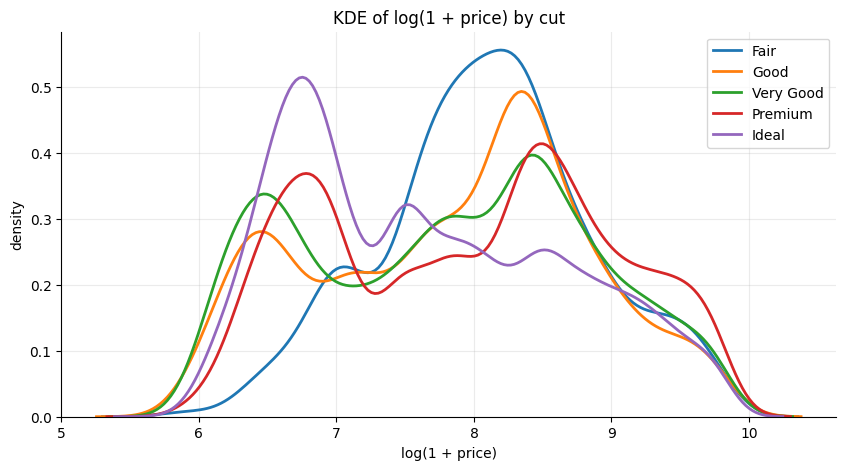

,cut,n,mean,median,std,p10,p90
0,Fair,1610,4358.757764,3282.0,3560.386612,1114.0,9133.7
1,Good,4906,3928.864452,3050.5,3681.589584,603.0,8736.0
2,Very Good,12082,3981.759891,2648.0,3935.862161,576.0,9680.9
3,Premium,13791,4584.257704,3185.0,4349.204961,709.0,11413.0
4,Ideal,21551,3457.541970,1810.0,3808.401172,652.0,9077.0


In [11]:
# Compare price distributions across diamond cut categories
diamonds2 = diamonds.copy()
diamonds2["price"] = pd.to_numeric(diamonds2["price"], errors="coerce")
diamonds2["log1p_price"] = np.log1p(diamonds2["price"])

# Order categories in a readable way if present
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
if "cut" in diamonds2.columns:
    # Keep only observed categories
    observed = [c for c in cut_order if c in diamonds2["cut"].dropna().unique()]
    if observed:
        diamonds2["cut"] = pd.Categorical(diamonds2["cut"], categories=observed, ordered=True)

# Box plot: robust comparison of medians and spread
if "cut" in diamonds2.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    if _HAS_SEABORN:
        sns.boxplot(data=diamonds2, x="cut", y="log1p_price", ax=ax)
    else:
        # Fallback: matplotlib boxplot
        groups = [diamonds2.loc[diamonds2["cut"] == c, "log1p_price"].dropna().to_numpy()
                  for c in diamonds2["cut"].cat.categories]
        ax.boxplot(groups, labels=list(diamonds2["cut"].cat.categories))
    ax.set_title("log(1 + price) by cut (box plot)")
    ax.set_xlabel("cut")
    ax.set_ylabel("log(1 + price)")
    plt.show()

# Violin plot: a density-aware alternative (requires seaborn)
if _HAS_SEABORN and "cut" in diamonds2.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(data=diamonds2, x="cut", y="log1p_price", ax=ax, inner="quartile", cut=0)
    ax.set_title("log(1 + price) by cut (violin plot)")
    ax.set_xlabel("cut")
    ax.set_ylabel("log(1 + price)")
    plt.show()

# Overlay KDEs: shape comparison
if _HAS_SEABORN and "cut" in diamonds2.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    for c in diamonds2["cut"].cat.categories:
        s = diamonds2.loc[diamonds2["cut"] == c, "log1p_price"].dropna()
        if len(s) > 10:
            sns.kdeplot(s, ax=ax, label=str(c), linewidth=2)
    ax.set_title("KDE of log(1 + price) by cut")
    ax.set_xlabel("log(1 + price)")
    ax.set_ylabel("density")
    ax.legend()
    plt.show()

# Summary statistics per group
if "cut" in diamonds2.columns:
    summary = (diamonds2
               .groupby("cut")["price"]
               .agg(n="count", mean="mean", median="median", std="std",
                    p10=lambda s: np.nanpercentile(s, 10),
                    p90=lambda s: np.nanpercentile(s, 90))
               .reset_index())
    display(summary)



### 6) Categorical and discrete distributions

Not all important features are continuous.
Categorical features appear everywhere in tabular ML (sex, region, product type, etc.).

For a categorical variable $C$ taking values in $\{1,\ldots,K\}$, the distribution is defined by probabilities:
$$
p_k = \mathbb{P}(C=k), \quad k=1,\ldots,K.
$$

From data, you estimate $p_k$ with relative frequencies:
$$
\hat p_k = \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{C_i = k\}.
$$

A bar chart of counts or proportions is the most direct visualization.
For two categorical variables, contingency tables and stacked/proportional bars reveal dependence.

We will use `drug200.csv`, which includes categorical columns such as `Sex`, `BP`, `Cholesterol`, and the label `Drug`.


In [12]:
# Dataset 2 (Classification): drug200
drug_path = "../../../Datasets/Classification/drug200.csv"
drug = read_csv_rel(drug_path)

quick_overview(drug, name="drug200")


drug200: shape=(200, 6)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY



Column types:


,dtype
Age,int64
Sex,object
BP,object
Cholesterol,object
Na_to_K,float64
Drug,object



Missing values (%):


,missing_%
Age,0.0
Sex,0.0
BP,0.0
Cholesterol,0.0
Na_to_K,0.0
Drug,0.0


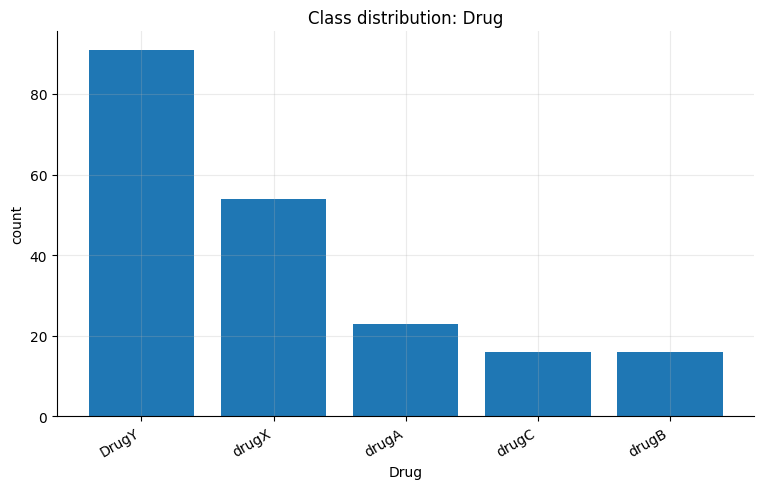

,proportion
Drug,
DrugY,0.455
drugX,0.270
drugA,0.115
drugC,0.080
drugB,0.080


Drug,DrugY,drugA,drugB,drugC,drugX
Sex,,,,,
F,0.489583,0.093750,0.062500,0.072917,0.281250
M,0.423077,0.134615,0.096154,0.086538,0.259615


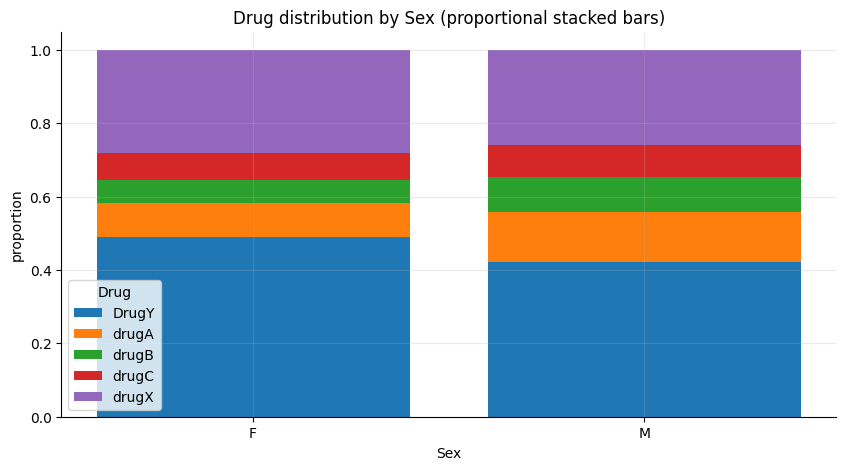

In [13]:
# Distribution of the target label: Drug
fig, ax = plt.subplots()
counts = drug["Drug"].value_counts(dropna=False)
ax.bar(counts.index.astype(str), counts.values)
ax.set_title("Class distribution: Drug")
ax.set_xlabel("Drug")
ax.set_ylabel("count")
plt.xticks(rotation=30, ha="right")
plt.show()

# Proportions
props = counts / counts.sum()
display(props.to_frame("proportion"))

# Stacked proportions of Drug by Sex
if "Sex" in drug.columns:
    ct = pd.crosstab(drug["Sex"], drug["Drug"], normalize="index")
    display(ct)

    fig, ax = plt.subplots(figsize=(10, 5))
    bottom = np.zeros(ct.shape[0])
    for col in ct.columns:
        ax.bar(ct.index.astype(str), ct[col].values, bottom=bottom, label=str(col))
        bottom += ct[col].values
    ax.set_title("Drug distribution by Sex (proportional stacked bars)")
    ax.set_xlabel("Sex")
    ax.set_ylabel("proportion")
    ax.legend(title="Drug")
    plt.show()



### 7) Quantifying uncertainty: confidence intervals for category proportions

When $n$ is not extremely large, class proportions are *estimates* with uncertainty.

For a binary category with count $k$ out of $n$, the sample proportion is $\hat p = k/n$.
A useful confidence interval is the **Wilson interval** (more stable than the naive normal approximation):
$$
\hat p_W = \frac{\hat p + \frac{z^2}{2n}}{1 + \frac{z^2}{n}},
\qquad
\text{half-width} = \frac{z}{1 + \frac{z^2}{n}}
\sqrt{\frac{\hat p(1-\hat p)}{n} + \frac{z^2}{4n^2}},
$$
where $z$ is the standard normal critical value (e.g., $z \approx 1.96$ for 95\%).

In multiclass settings you can compute a Wilson interval per class (treating class vs “not class”).
This is often enough for quick EDA to understand if apparent differences are meaningful.


,Drug,count,proportion,CI95_low,CI95_high
0,DrugY,91,0.455,0.387481,0.524215
1,drugX,54,0.270,0.213234,0.335436
2,drugA,23,0.115,0.077863,0.166648
3,drugC,16,0.080,0.049840,0.125990
4,drugB,16,0.080,0.049840,0.125990


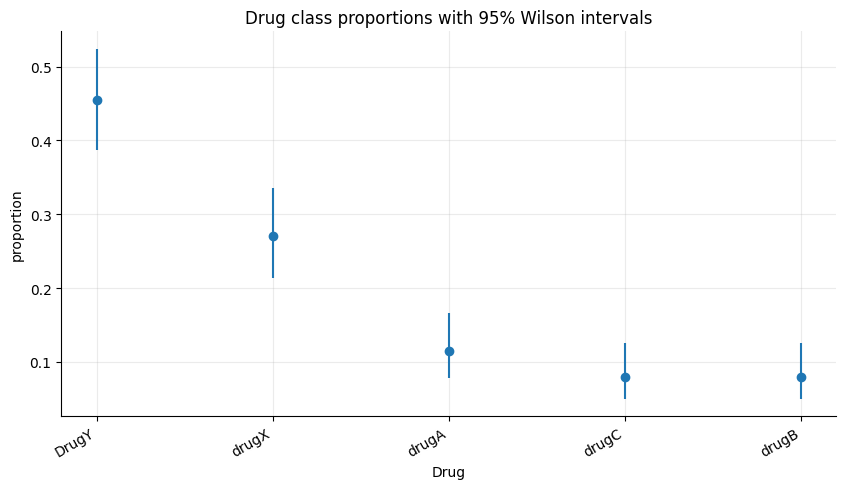

In [14]:
def wilson_interval(k: int, n: int, z: float = 1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + (z**2) / n
    center = (phat + (z**2) / (2*n)) / denom
    half = (z / denom) * np.sqrt((phat*(1-phat)/n) + (z**2)/(4*n**2))
    return (center - half, center + half)

# Wilson intervals for each Drug class proportion
n = len(drug)
rows = []
for cls, k in counts.items():
    lo, hi = wilson_interval(int(k), n, z=1.96)
    rows.append({"Drug": str(cls), "count": int(k), "proportion": k/n, "CI95_low": lo, "CI95_high": hi})
ci_df = pd.DataFrame(rows).sort_values("proportion", ascending=False)
display(ci_df)

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(
    x=np.arange(len(ci_df)),
    y=ci_df["proportion"],
    yerr=[ci_df["proportion"] - ci_df["CI95_low"], ci_df["CI95_high"] - ci_df["proportion"]],
    fmt="o"
)
ax.set_xticks(np.arange(len(ci_df)))
ax.set_xticklabels(ci_df["Drug"], rotation=30, ha="right")
ax.set_title("Drug class proportions with 95% Wilson intervals")
ax.set_xlabel("Drug")
ax.set_ylabel("proportion")
plt.show()



### 8) Numeric distributions with “target-like” variables (example: Wine Quality)

In EDA for supervised learning, you frequently have:

- many numeric features,
- a target that can be discrete or ordinal (e.g., `quality`).

You should visualize:

- marginal feature distributions (skewness, outliers, scaling),
- the target distribution (class imbalance / label noise),
- feature distributions conditioned on target (separation, monotonic trends),
- joint distributions for correlated features (multicollinearity signals).

We will use `Wine_Quality.csv`.


In [15]:
# Dataset 3 (Classification-like / ordinal target): Wine Quality
wine_path = "../../../Datasets/Classification/Wine_Quality.csv"
wine = read_csv_rel(wine_path)

quick_overview(wine, name="Wine_Quality")


Wine_Quality: shape=(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



Column types:


,dtype
fixed acidity,float64
volatile acidity,float64
citric acid,float64
residual sugar,float64
chlorides,float64
free sulfur dioxide,float64
total sulfur dioxide,float64
density,float64
pH,float64
sulphates,float64



Missing values (%):


,missing_%
fixed acidity,0.0
volatile acidity,0.0
citric acid,0.0
residual sugar,0.0
chlorides,0.0
free sulfur dioxide,0.0
total sulfur dioxide,0.0
density,0.0
pH,0.0
sulphates,0.0


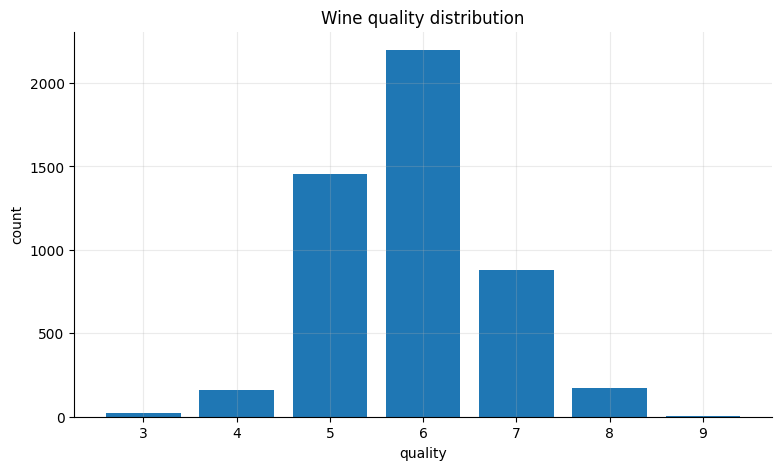

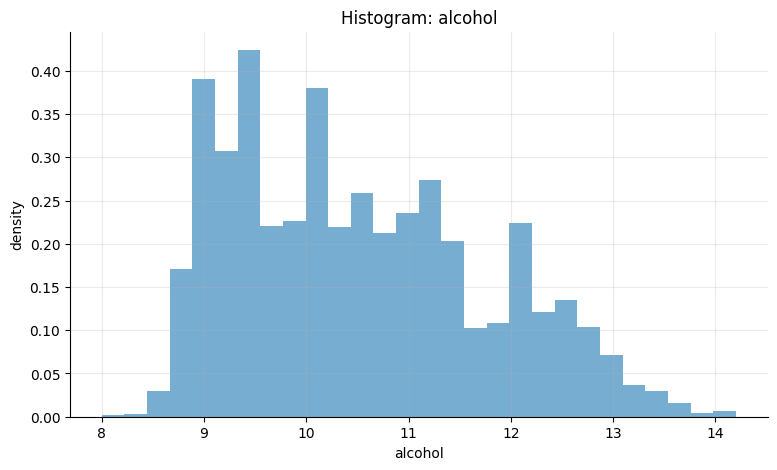

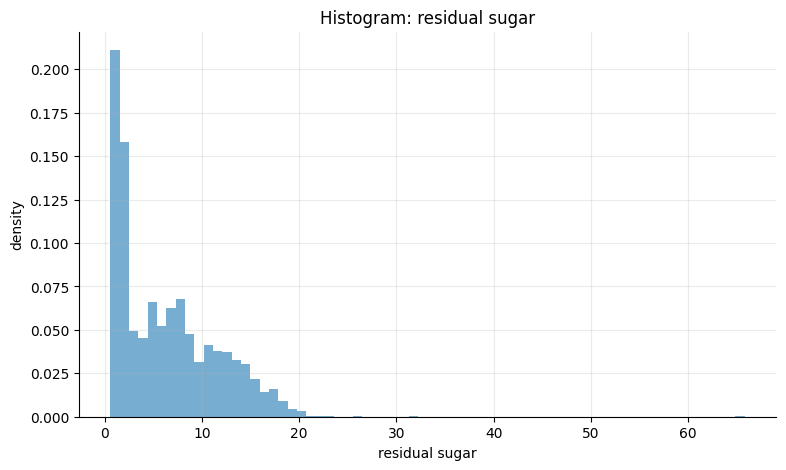

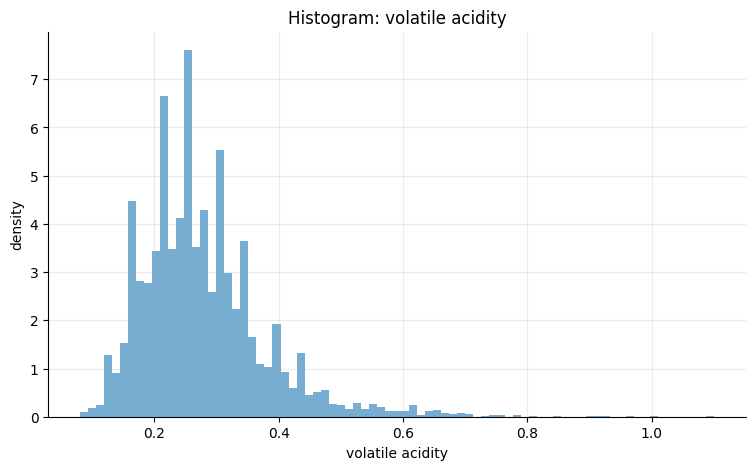

In [16]:
# Target distribution: quality (often treated as ordinal)
fig, ax = plt.subplots()
q_counts = wine["quality"].value_counts().sort_index()
ax.bar(q_counts.index.astype(str), q_counts.values)
ax.set_title("Wine quality distribution")
ax.set_xlabel("quality")
ax.set_ylabel("count")
plt.show()

# Example feature distributions: alcohol and residual sugar
for col in ["alcohol", "residual sugar", "volatile acidity"]:
    if col in wine.columns:
        s = pd.to_numeric(wine[col], errors="coerce").dropna()
        fig, ax = plt.subplots()
        ax.hist(s, bins=freedman_diaconis_bins(s), density=True, alpha=0.6)
        ax.set_title(f"Histogram: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("density")
        plt.show()


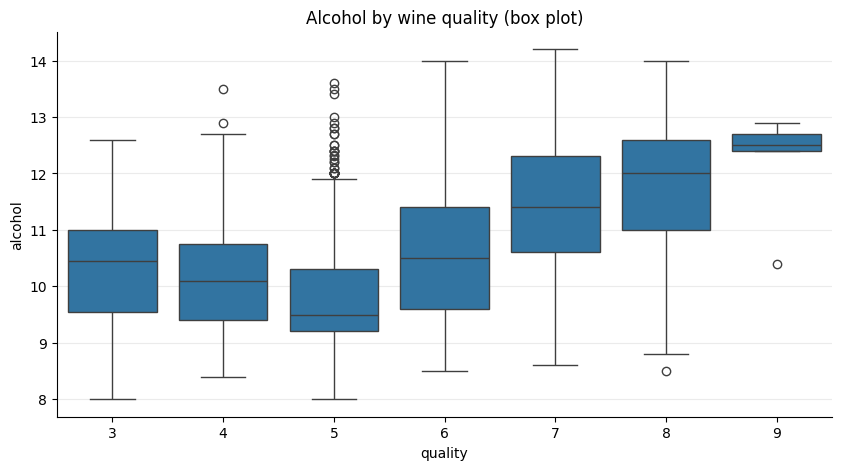

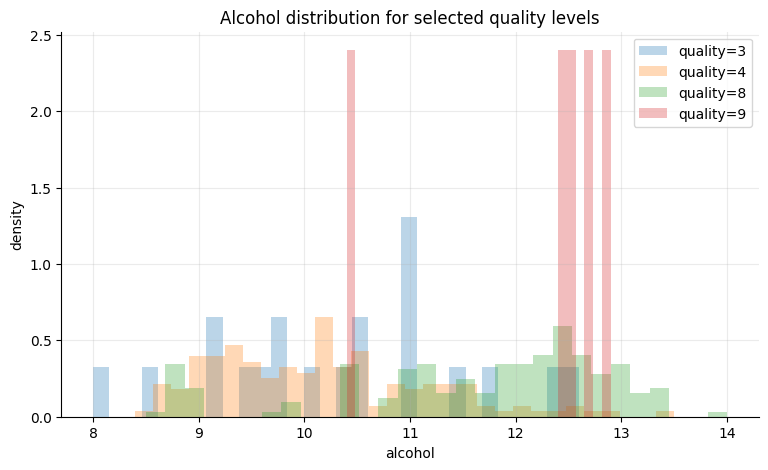

In [17]:
# Conditional distributions: alcohol by quality
if _HAS_SEABORN and "alcohol" in wine.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=wine, x="quality", y="alcohol", ax=ax)
    ax.set_title("Alcohol by wine quality (box plot)")
    ax.set_xlabel("quality")
    ax.set_ylabel("alcohol")
    plt.show()

# Overlaid histograms for a subset of qualities
if "alcohol" in wine.columns:
    qualities = sorted(wine["quality"].dropna().unique())
    chosen = qualities[:2] + qualities[-2:] if len(qualities) >= 4 else qualities
    series_list = [wine.loc[wine["quality"] == q, "alcohol"] for q in chosen]
    fig, ax = plt.subplots()
    overlay_hist(ax, series_list, labels=[f"quality={q}" for q in chosen],
                 bins=30, density=True, alpha=0.3)
    ax.set_title("Alcohol distribution for selected quality levels")
    ax.set_xlabel("alcohol")
    ax.set_ylabel("density")
    plt.show()



### 9) Joint distributions (bivariate and multivariate views)

A single-variable distribution can be misleading if features interact.
Two patterns often matter in ML EDA:

- **Correlation and collinearity**: redundant information, unstable coefficients.
- **Nonlinear structure**: clusters, regimes, or heteroskedasticity.

Bivariate plots for numeric–numeric pairs:

- Scatter plot (good for small/medium $n$),
- Hexbin / 2D histogram (good for larger $n$),
- Contours / joint KDE (requires smoothing assumptions).

You should combine these with correlation summaries.


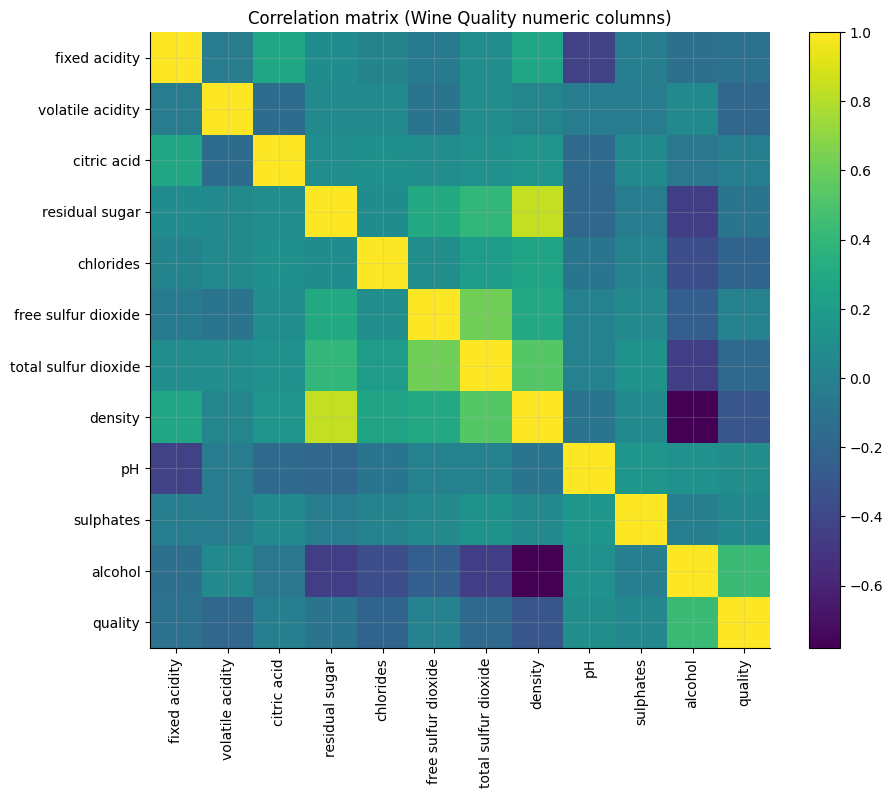

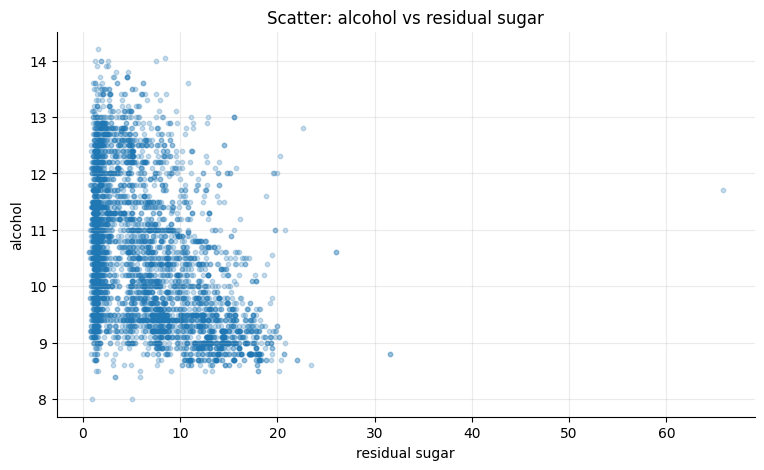

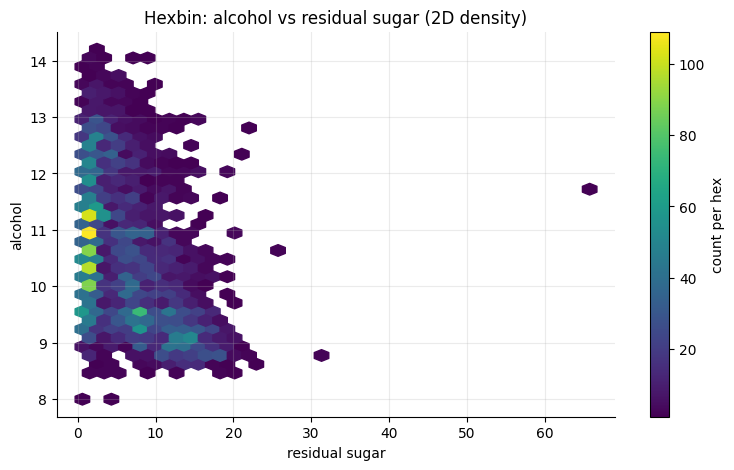

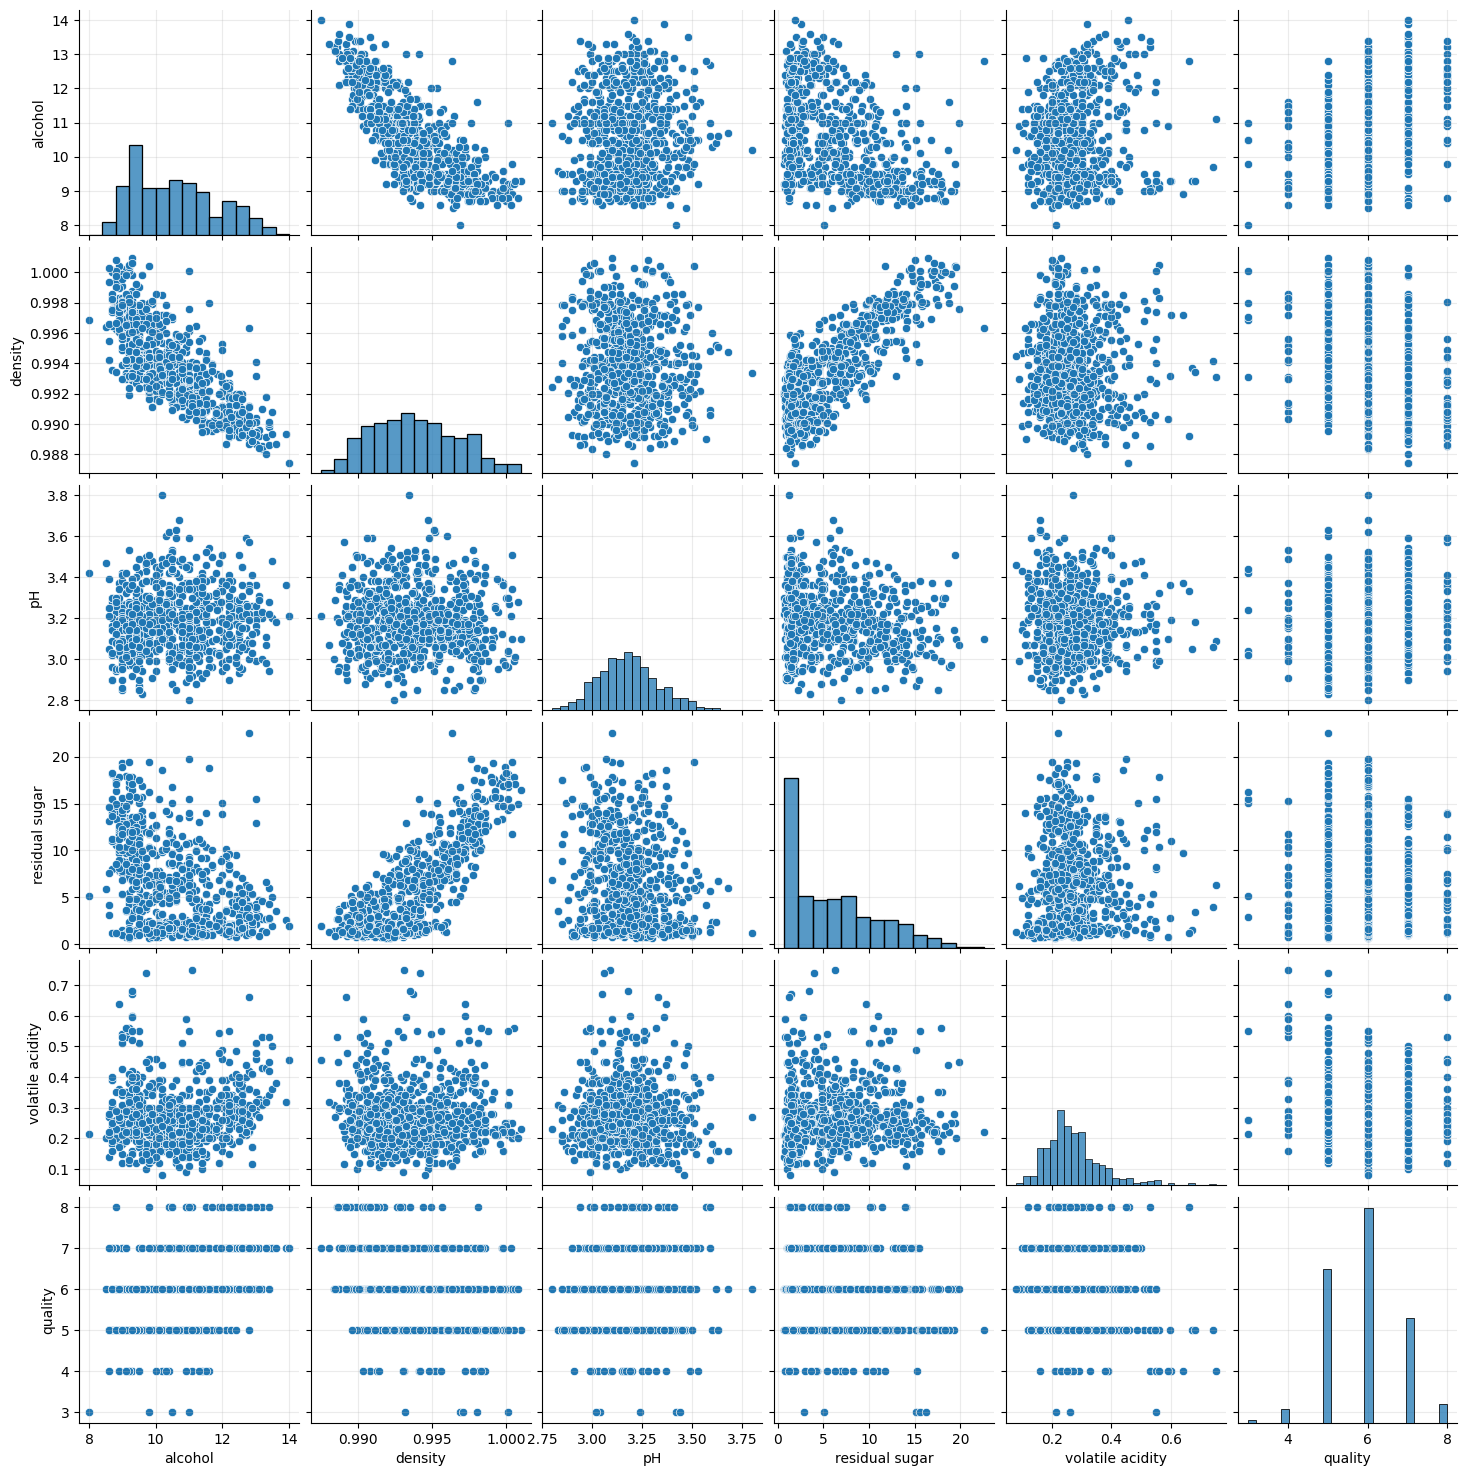

In [18]:
# Correlation overview (numeric columns)
num_cols = wine.select_dtypes(include=[np.number]).columns
corr = wine[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values, aspect="auto")
ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
ax.set_title("Correlation matrix (Wine Quality numeric columns)")
plt.colorbar(im, ax=ax)
plt.show()

# Example joint distribution: alcohol vs residual sugar
if {"alcohol", "residual sugar"}.issubset(wine.columns):
    x = pd.to_numeric(wine["residual sugar"], errors="coerce")
    y = pd.to_numeric(wine["alcohol"], errors="coerce")
    m = x.notna() & y.notna()
    x = x[m].to_numpy()
    y = y[m].to_numpy()

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=10, alpha=0.25)
    ax.set_title("Scatter: alcohol vs residual sugar")
    ax.set_xlabel("residual sugar")
    ax.set_ylabel("alcohol")
    plt.show()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=35, mincnt=1)
    ax.set_title("Hexbin: alcohol vs residual sugar (2D density)")
    ax.set_xlabel("residual sugar")
    ax.set_ylabel("alcohol")
    plt.colorbar(hb, ax=ax, label="count per hex")
    plt.show()

# Pairwise relationships (requires seaborn)
if _HAS_SEABORN:
    subset_cols = [c for c in ["alcohol", "density", "pH", "residual sugar", "volatile acidity", "quality"] if c in wine.columns]
    if len(subset_cols) >= 3:
        sns.pairplot(wine[subset_cols].dropna().sample(min(800, len(wine)), random_state=42), diag_kind="hist")



### 10) Distribution shift diagnostics (train vs test vs production)

For ML, *distribution shift* is one of the most common reasons models degrade after deployment.

Two simple, practical checks you can run during EDA:

1) **Visual overlap check**:
   - overlay histograms or KDEs of a feature for two samples (e.g., train vs test).
2) **Quantitative distance / test**:
   - Kolmogorov–Smirnov (KS) statistic for continuous features,
   - Chi-square style comparisons for categorical features,
   - Population Stability Index (PSI) as a heuristic drift score.

These tools do not “prove” drift, but they raise or reduce suspicion quickly.

We will illustrate with `diabetes.csv` and compare feature distributions between a random train/test split.


In [19]:
# Dataset 4 (Classification): diabetes
diabetes_path = "../../../Datasets/Classification/diabetes.csv"
diabetes = read_csv_rel(diabetes_path)

quick_overview(diabetes, name="diabetes")


diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic



Column types:


,dtype
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
classification,object



Missing values (%):


,missing_%
Pregnancies,0.0
Glucose,0.0
BloodPressure,0.0
SkinThickness,0.0
Insulin,0.0
BMI,0.0
DiabetesPedigreeFunction,0.0
Age,0.0
classification,0.0


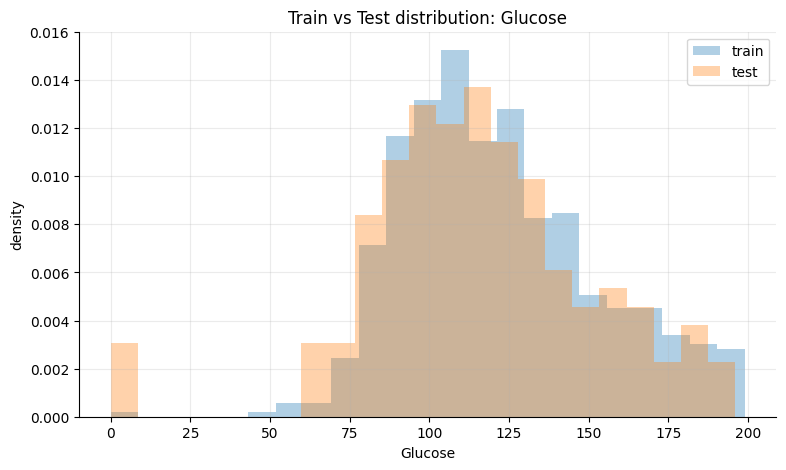

KS statistic for Glucose (train vs test): 0.0774
SciPy KS test: KstestResult(statistic=np.float64(0.07735098777444055), pvalue=np.float64(0.42670665938923175), statistic_location=np.int64(94), statistic_sign=np.int8(-1))
PSI for Glucose (train as expected, test as actual): 0.0382


In [20]:
# Create a train/test split and compare a numeric feature distribution
rng = np.random.default_rng(42)
idx = np.arange(len(diabetes))
rng.shuffle(idx)

train_idx = idx[: int(0.8 * len(idx))]
test_idx = idx[int(0.8 * len(idx)) :]

train = diabetes.iloc[train_idx].copy()
test = diabetes.iloc[test_idx].copy()

feature = "Glucose" if "Glucose" in diabetes.columns else diabetes.select_dtypes(include=[np.number]).columns[0]

x_train = pd.to_numeric(train[feature], errors="coerce").dropna()
x_test = pd.to_numeric(test[feature], errors="coerce").dropna()

fig, ax = plt.subplots()
bins = freedman_diaconis_bins(pd.concat([x_train, x_test], ignore_index=True))
overlay_hist(ax, [x_train, x_test], ["train", "test"], bins=bins, density=True, alpha=0.35)
ax.set_title(f"Train vs Test distribution: {feature}")
ax.set_xlabel(feature)
ax.set_ylabel("density")
plt.show()

# KS statistic (continuous)
def ks_statistic(a: np.ndarray, b: np.ndarray) -> float:
    a = np.sort(a[np.isfinite(a)])
    b = np.sort(b[np.isfinite(b)])
    na, nb = len(a), len(b)
    if na == 0 or nb == 0:
        return np.nan
    i = j = 0
    cdf_a = cdf_b = 0.0
    d = 0.0
    while i < na and j < nb:
        if a[i] <= b[j]:
            i += 1
            cdf_a = i / na
        else:
            j += 1
            cdf_b = j / nb
        d = max(d, abs(cdf_a - cdf_b))
    # finish remaining
    while i < na:
        i += 1
        cdf_a = i / na
        d = max(d, abs(cdf_a - cdf_b))
    while j < nb:
        j += 1
        cdf_b = j / nb
        d = max(d, abs(cdf_a - cdf_b))
    return d

ks_d = ks_statistic(x_train.to_numpy(), x_test.to_numpy())
print(f"KS statistic for {feature} (train vs test): {ks_d:.4f}")

if _HAS_SCIPY:
    ks_res = stats.ks_2samp(x_train, x_test)
    print("SciPy KS test:", ks_res)

# PSI (Population Stability Index)
def population_stability_index(expected: np.ndarray, actual: np.ndarray, bins: int = 10) -> float:
    expected = expected[np.isfinite(expected)]
    actual = actual[np.isfinite(actual)]
    if expected.size == 0 or actual.size == 0:
        return np.nan
    # Use quantile-based bins from expected sample
    quantiles = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(expected, quantiles))
    if edges.size < 3:
        return 0.0
    exp_counts, _ = np.histogram(expected, bins=edges)
    act_counts, _ = np.histogram(actual, bins=edges)

    exp_perc = exp_counts / exp_counts.sum()
    act_perc = act_counts / act_counts.sum()

    # avoid zeros
    eps = 1e-6
    exp_perc = np.clip(exp_perc, eps, 1)
    act_perc = np.clip(act_perc, eps, 1)

    psi = np.sum((act_perc - exp_perc) * np.log(act_perc / exp_perc))
    return float(psi)

psi_val = population_stability_index(x_train.to_numpy(), x_test.to_numpy(), bins=10)
print(f"PSI for {feature} (train as expected, test as actual): {psi_val:.4f}")



### 11) Transformations for visualization (and for modeling)

Sometimes the distribution’s shape is not “nice” in the raw scale, but becomes interpretable after a monotone transform.

Common patterns:

- **Positive, heavy-tailed variables** (prices, income, counts):
  - Log transform: $y = \log(1+x)$
- **Multiplicative variability**:
  - Log transform often makes variance more stable.
- **Bounded variables** (probabilities in $[0,1]$):
  - Logit transform: $y = \log\frac{p}{1-p}$ (be careful with 0/1).
- **Power transforms** (Box–Cox, Yeo–Johnson):
  - can reduce skewness, but should be used with caution for interpretability.

A key principle:

> A monotone transform preserves rank but changes distance.

So for purely “shape understanding,” transforms are powerful.
For modeling, you also consider what the transform implies for loss functions and error interpretation.

Example: If you model $\log(1 + y)$ with squared loss, you implicitly penalize *relative* errors more than absolute errors.


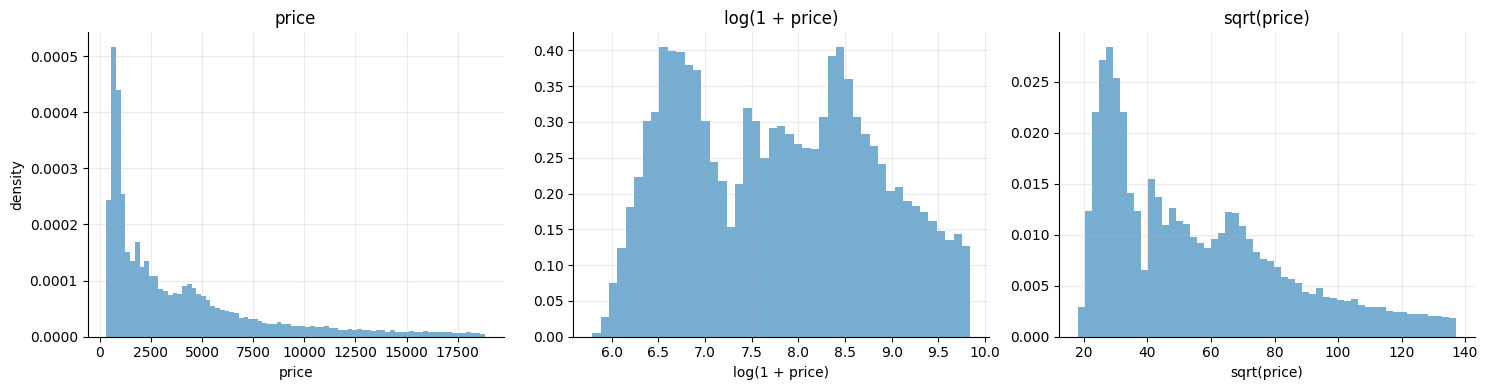

Skewness:
  price:        1.618
  log1p(price): 0.116
  sqrt(price):  0.844


In [21]:
# Demonstrate how a transform changes perceived skewness using diamonds price
# We'll compare price, log1p(price), and sqrt(price) in one figure.

price_arr = price.to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(price_arr, bins=freedman_diaconis_bins(price), density=True, alpha=0.6)
axes[0].set_title("price")
axes[0].set_xlabel("price")
axes[0].set_ylabel("density")

axes[1].hist(np.log1p(price_arr), bins=freedman_diaconis_bins(log_price), density=True, alpha=0.6)
axes[1].set_title("log(1 + price)")
axes[1].set_xlabel("log(1 + price)")

axes[2].hist(np.sqrt(price_arr), bins=freedman_diaconis_bins(np.sqrt(price_arr)), density=True, alpha=0.6)
axes[2].set_title("sqrt(price)")
axes[2].set_xlabel("sqrt(price)")

plt.tight_layout()
plt.show()

# Quick skewness estimate (Fisher-Pearson) without extra dependencies
def skewness(x: np.ndarray) -> float:
    x = x[np.isfinite(x)]
    n = x.size
    if n < 3:
        return np.nan
    m = x.mean()
    s = x.std(ddof=0)
    if s == 0:
        return 0.0
    return float(np.mean(((x - m) / s) ** 3))

print("Skewness:")
print(f"  price:        {skewness(price_arr):.3f}")
print(f"  log1p(price): {skewness(np.log1p(price_arr)):.3f}")
print(f"  sqrt(price):  {skewness(np.sqrt(price_arr)):.3f}")



### 12) Outliers: visualization and robust summaries

Outliers can be:

- **data quality issues** (measurement error, unit mismatch),
- **rare but valid events** (tail behavior you *must* model),
- **subpopulation signals** (a hidden segment).

Before removing outliers, you should visualize them and understand their origin.

Two robust tools you can use immediately:

- **Box plot** uses quartiles and IQR.
  - A common rule marks points beyond $[Q_{0.25} - 1.5\,\text{IQR},\ Q_{0.75} + 1.5\,\text{IQR}]$ as outliers.
- **Median Absolute Deviation (MAD)**:
  $$
  \text{MAD} = \text{median}(|x_i - \text{median}(x)|).
  $$
  A robust z-score can be formed as:
  $$
  z_i^{\text{rob}} = \frac{x_i - \text{median}(x)}{1.4826 \cdot \text{MAD}},
  $$
  where $1.4826$ makes the estimator consistent for normal data.

Robust summaries help you avoid letting a few extreme values dominate your interpretation.


residual sugar: n=4898, outliers_by_IQR_rule=7 (0.14%)


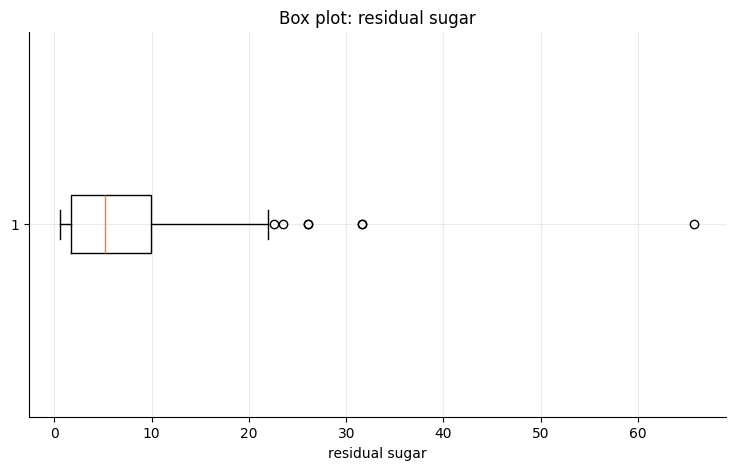

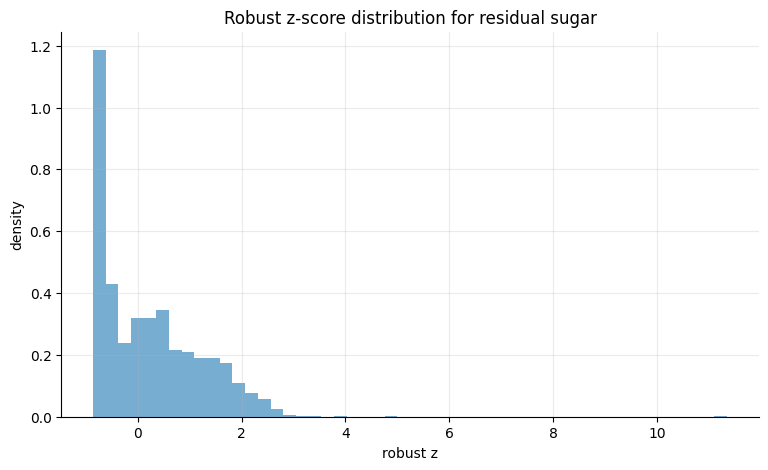

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2781,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6
1663,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
1653,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
3619,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
3623,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
1608,6.9,0.270,0.49,23.50,0.057,59.0,235.0,1.00240,2.98,0.47,8.6,5
4480,5.9,0.220,0.45,22.60,0.120,55.0,122.0,0.99636,3.10,0.35,12.8,5
191,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
182,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
444,6.9,0.240,0.36,20.80,0.031,40.0,139.0,0.99750,3.20,0.33,11.0,6


In [22]:
# Outlier inspection example: Wine residual sugar (often skewed with extremes)
col = "residual sugar" if "residual sugar" in wine.columns else wine.select_dtypes(include=[np.number]).columns[0]
x = pd.to_numeric(wine[col], errors="coerce").dropna()

q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lo = q1 - 1.5 * iqr
hi = q3 + 1.5 * iqr

outliers = x[(x < lo) | (x > hi)]
print(f"{col}: n={len(x)}, outliers_by_IQR_rule={len(outliers)} ({len(outliers)/len(x):.2%})")

fig, ax = plt.subplots()
ax.boxplot(x.to_numpy(), vert=False)
ax.set_title(f"Box plot: {col}")
ax.set_xlabel(col)
plt.show()

# Robust z-scores via MAD
med = np.median(x)
mad = np.median(np.abs(x - med))
robust_sigma = 1.4826 * mad if mad > 0 else np.std(x)
z_rob = (x - med) / (robust_sigma if robust_sigma > 0 else 1.0)

fig, ax = plt.subplots()
ax.hist(z_rob, bins=50, density=True, alpha=0.6)
ax.set_title(f"Robust z-score distribution for {col}")
ax.set_xlabel("robust z")
ax.set_ylabel("density")
plt.show()

# Show the most extreme rows (by robust z-score) for context
extreme_idx = np.argsort(np.abs(z_rob.to_numpy()))[::-1][:10]
display(wine.loc[x.index[extreme_idx]].head(10))



### 14) Common pitfalls when visualizing distributions

Even experienced practitioners can misread distribution plots.
Here are common pitfalls and how to avoid them.

**Pitfall A — confusing counts with densities**

A histogram can show:

- **counts**: bar heights sum to $n$ (up to binning),
- **density**: total area is approximately 1.

If you compare groups with different sample sizes, density is usually the right choice.
If you care about absolute volume, counts are informative.

**Pitfall B — hiding multimodality by over-smoothing**

A large bandwidth in KDE can merge distinct modes.
If you suspect mixtures or segments, reduce bandwidth and/or compare with histograms.

**Pitfall C — “bin-endpoint artifacts”**

Shifting bin edges can change the visual story.
To build confidence, check stability across a few bin settings.

**Pitfall D — plotting raw scale when log scale is needed**

Heavy-tailed variables often look like “everything is near zero” on raw scale.
Try:
- log transform on values,
- log axis (when values are strictly positive).

**Pitfall E — ignoring measurement granularity**

If data are integer-valued (counts) or have rounding, KDE can mislead.
Use bar charts or histograms with integer-aligned bins.

**Pitfall F — drawing conclusions from tiny samples**

Small $n$ can produce highly variable shapes.
Use ECDF and show uncertainty (e.g., bootstrap bands) when needed.

In practice, you want your conclusions to be *robust to visualization choices*.


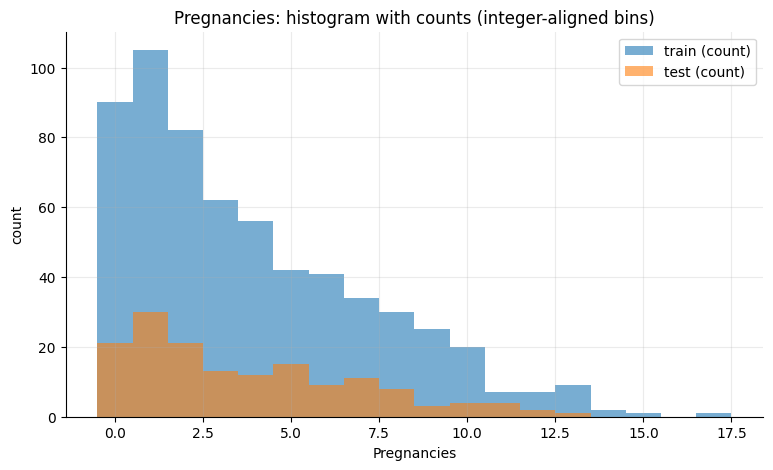

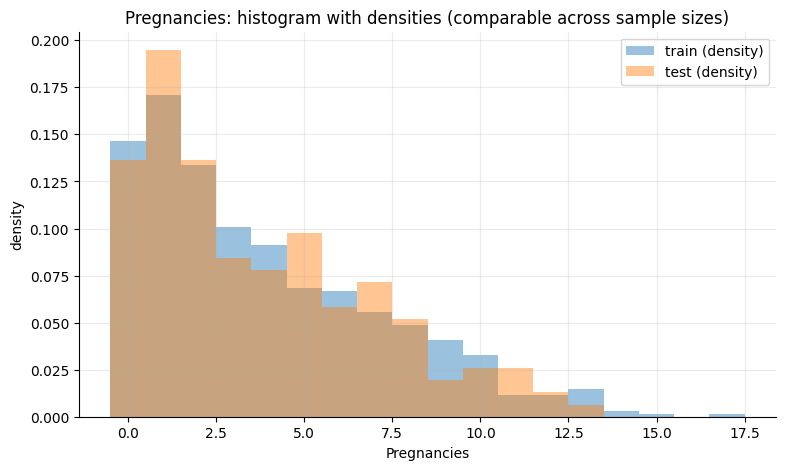

In [23]:
# Illustration of counts vs density and discrete-valued features

# Example: pregnancies is an integer feature in diabetes
if "Pregnancies" in diabetes.columns:
    preg_train = pd.to_numeric(train["Pregnancies"], errors="coerce").dropna().astype(int)
    preg_test = pd.to_numeric(test["Pregnancies"], errors="coerce").dropna().astype(int)

    # Count-based histogram
    fig, ax = plt.subplots()
    bins = np.arange(preg_train.min(), preg_train.max() + 2) - 0.5
    ax.hist(preg_train, bins=bins, alpha=0.6, label="train (count)")
    ax.hist(preg_test, bins=bins, alpha=0.6, label="test (count)")
    ax.set_title("Pregnancies: histogram with counts (integer-aligned bins)")
    ax.set_xlabel("Pregnancies")
    ax.set_ylabel("count")
    ax.legend()
    plt.show()

    # Density-based histogram
    fig, ax = plt.subplots()
    ax.hist(preg_train, bins=bins, density=True, alpha=0.45, label="train (density)")
    ax.hist(preg_test, bins=bins, density=True, alpha=0.45, label="test (density)")
    ax.set_title("Pregnancies: histogram with densities (comparable across sample sizes)")
    ax.set_xlabel("Pregnancies")
    ax.set_ylabel("density")
    ax.legend()
    plt.show()



### 13) Practical checklist for “visualize distributions” in ML EDA

When you approach a new dataset, a reliable workflow is:

1) **Start with marginals**
   - For each numeric feature: histogram + (optional) KDE + summary stats.
   - For each categorical feature: counts + proportions.

2) **Check for scale and tail issues**
   - Are there orders-of-magnitude differences? Try log scale.
   - Are there extreme values that dominate variance? Use robust summaries.

3) **Compare conditional distributions**
   - By target label or key segments (region, product category, etc.).
   - Look for overlaps, separation, and multimodality.

4) **Inspect joint structure for key pairs**
   - Correlated features can make linear models unstable.
   - Nonlinear patterns might suggest tree-based models or feature engineering.

5) **Validate split consistency**
   - Overlay distributions across train/validation/test.
   - Use KS/PSI heuristics to prioritize deeper investigation.

A final reminder: visualization is not a one-off step.
It is iterative—each plot creates hypotheses that you test with the next plot.

---

### Exercises

1) Using the `diabetes` dataset:
   - pick three numeric columns,
   - visualize their distributions (hist + ECDF),
   - try a log transform on one column (if all values are positive),
   - write 2–3 sentences about what you learned.

2) Using `drug200`:
   - plot the distribution of `BP` and `Cholesterol`,
   - compute and plot the proportional distribution of `Drug` conditioned on `BP`,
   - identify whether the class distribution is imbalanced.

3) Using `Wine_Quality`:
   - pick two numeric features and draw a hexbin plot,
   - compute correlations and identify a strongly correlated pair,
   - hypothesize how multicollinearity might affect a linear model.

If you can complete these exercises, you can confidently perform the “distribution” phase of EDA on new tabular datasets.
